In [1]:
import os
import re
import math
import pickle
import random
import Orange
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from humanize import ordinal
from scikit_posthocs import posthoc_nemenyi
from scipy.stats import mannwhitneyu
from scipy.spatial import ConvexHull
from skcriteria import Data, MAX
from skcriteria.madm.closeness import TOPSIS
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import LeaveOneOut
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
RESULTS_PATH = 'data/results'
TASKS_FEATURES_FILEPATH = 'data/tasks_features.pkl'

In [3]:
results_dfs = {}
for filename in os.listdir(RESULTS_PATH):
    archtecture = re.search(r'(?<=results_).*(?=.csv)', filename).group()
    results_dfs[archtecture] = pd.read_csv(os.path.join(RESULTS_PATH, filename))

In [4]:
results_df = pd.concat(results_dfs.values(), ignore_index=True)

In [5]:
results_df.head()

,Architecture,Task,Accuracy_vector,Precision_vector,Recall_vector,F1_vector,Accuracy_avg,Precision_avg,Recall_avg,F1_avg
0,ResNet10,airplane-automobile,"[0.942, 0.939, 0.93, 0.9275, 0.916, 0.9315, 0....","[0.9203510204081633, 0.9051657032755298, 0.893...","[0.932, 0.958, 0.948, 0.939, 0.954, 0.938, 0.8...","[0.9414141414141414, 0.9401373895976447, 0.931...",0.92505,0.892683,0.9274,0.925149
1,ResNet10,airplane-bird,"[0.89, 0.889, 0.8935, 0.882, 0.875, 0.8895, 0....","[0.8614113785557986, 0.8492249488752557, 0.852...","[0.847, 0.878, 0.89, 0.886, 0.888, 0.89, 0.887...","[0.8850574712643677, 0.8877654196157735, 0.893...",0.88480,0.843588,0.8753,0.883662
2,ResNet10,airplane-cat,"[0.9245, 0.9325, 0.935, 0.926, 0.932, 0.925, 0...","[0.8897871921182265, 0.8980344995140912, 0.905...","[0.932, 0.947, 0.937, 0.938, 0.961, 0.909, 0.8...","[0.9250620347394541, 0.933464760965993, 0.9351...",0.92580,0.893557,0.9279,0.925876
3,ResNet10,airplane-deer,"[0.9475, 0.9125, 0.943, 0.93, 0.917, 0.936, 0....","[0.9234072781655036, 0.8553790534618757, 0.921...","[0.949, 0.983, 0.933, 0.98, 0.935, 0.928, 0.95...","[0.947578632051922, 0.9182624941616068, 0.9424...",0.93320,0.900529,0.9460,0.934192
4,ResNet10,airplane-dog,"[0.948, 0.9515, 0.936, 0.947, 0.9345, 0.9475, ...","[0.924704, 0.9361238390092881, 0.9224043010752...","[0.948, 0.936, 0.901, 0.95, 0.914, 0.93, 0.955...","[0.948, 0.9507364144235654, 0.9336787564766839...",0.94470,0.923633,0.9363,0.944177


In [6]:
TASKS = results_df['Task'].unique()
ARCHITECTURES = results_df['Architecture'].unique()

In [7]:
label_encoder = LabelEncoder()
label_encoder.fit(ARCHITECTURES)

LabelEncoder()

In [8]:
leave_one_out = LeaveOneOut()

In [9]:
metrics_avg = {}
metrics_vectors = {}
for task in TASKS:
    df = results_df.query(f'Task == "{task}"')
    metrics_avg[task] = {}
    metrics_vectors[task] = {}
    for _, row in df.iterrows():
        metrics_avg[task][row['Architecture']] = {
            'accuracy': row['Accuracy_avg'],
            'precision': row['Precision_avg'],
            'recall': row['Recall_avg'],
            'f1': row['F1_avg']
        }
        metrics_vectors[task][row['Architecture']] = {
            'accuracy': np.array(eval(row['Accuracy_vector'])),
            'precision': np.array(eval(row['Precision_vector'])),
            'recall': np.array(eval(row['Recall_vector'])),
            'f1': np.array(eval(row['F1_vector']))
        }

In [10]:
ranking_architectures = {}
for task in TASKS:
    metrics_columns = ['Accuracy_avg', 'Precision_avg', 'Recall_avg', 'F1_avg']
    metrics_df = results_df.query(f'Task == "{task}"')[metrics_columns]
    data = Data(metrics_df.to_numpy(), criteria=[MAX, MAX, MAX, MAX])
    topsis = TOPSIS()
    ranking_architectures[task] = results_df.iloc[
        metrics_df.index[np.argsort(topsis.decide(data).rank_)]
    ]['Architecture'].tolist()

In [11]:
%%time

mean_centroids = []
best_architectures = []
for task in TASKS:
    with open(f'data/tasks_features/{task}.pkl', 'rb') as f:
        task_features = pickle.load(f)
    task_features_normalized = normalize(task_features, axis=0)
    kmeans = KMeans(n_clusters=2, n_jobs=3)
    kmeans.fit(task_features_normalized)
    centroids = kmeans.cluster_centers_
    mean_centroids.append(np.add(*centroids) / centroids.shape[0])
    best_architectures.append(ranking_architectures[task][0])

CPU times: user 19.7 s, sys: 14.4 s, total: 34.1 s
Wall time: 9min 31s


In [12]:
X = np.array(mean_centroids)
y = label_encoder.transform(best_architectures)

In [13]:
lda = LinearDiscriminantAnalysis(n_components=2)

In [14]:
component_x, component_y = lda.fit_transform(X, y).T

In [15]:
AlexNet1_index = [i for i, architecture in enumerate(best_architectures) if architecture == 'AlexNet1']
MiniGoogLeNet1_index = [i for i, architecture in enumerate(best_architectures) if architecture == 'MiniGoogLeNet1']
MiniVGG1_index = [i for i, architecture in enumerate(best_architectures) if architecture == 'MiniVGG1']
MiniVGG3_index = [i for i, architecture in enumerate(best_architectures) if architecture == 'MiniVGG3']

In [16]:
def encircle(x, y, ax=None, **kw):
    if not ax:
        ax = plt.gca()
    p = np.c_[x,y]
    hull = ConvexHull(p)
    poly = plt.Polygon(p[hull.vertices, :], **kw)
    ax.add_patch(poly)

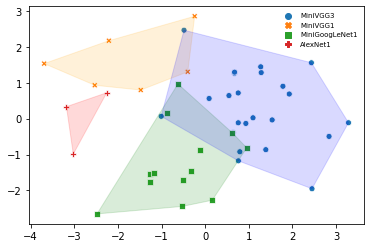

In [17]:
g = sns.scatterplot(component_x, component_y, hue=best_architectures, style=best_architectures)
g.legend(fontsize='x-small', frameon=False)

encircle(component_x[AlexNet1_index], component_y[AlexNet1_index], ec='red', fc='red', alpha=0.15)
encircle(component_x[MiniGoogLeNet1_index], component_y[MiniGoogLeNet1_index], ec='green', fc='green', alpha=0.15)
encircle(component_x[MiniVGG1_index], component_y[MiniVGG1_index], ec='orange', fc='orange', alpha=0.15)
encircle(component_x[MiniVGG3_index], component_y[MiniVGG3_index], ec='blue', fc='blue', alpha=0.15)

plt.savefig('datasets_map.png', dpi=1200, bbox_inches='tight')
plt.show()

In [18]:
%%time

knn_recommendations = {}
for train_index, test_index in leave_one_out.split(TASKS):
    clf = KNeighborsClassifier()
    clf.fit(X[train_index], y[train_index])
    task = TASKS[test_index[0]]
    recommended_architecture = label_encoder.inverse_transform(
        clf.predict(X[test_index])
    )[0]
    knn_recommendations[task] = recommended_architecture

CPU times: user 114 ms, sys: 3.17 ms, total: 118 ms
Wall time: 165 ms


In [19]:
%%time

svm_recommendations = {}
for train_index, test_index in leave_one_out.split(TASKS):
    clf = SVC()
    clf.fit(X[train_index], y[train_index])
    task = TASKS[test_index[0]]
    recommended_architecture = label_encoder.inverse_transform(
        clf.predict(X[test_index])
    )[0]
    svm_recommendations[task] = recommended_architecture

CPU times: user 313 ms, sys: 2.5 ms, total: 315 ms
Wall time: 368 ms


In [20]:
%%time

rf_recommendations = {}
for train_index, test_index in leave_one_out.split(TASKS):
    clf = RandomForestClassifier()
    clf.fit(X[train_index], y[train_index])
    task = TASKS[test_index[0]]
    recommended_architecture = label_encoder.inverse_transform(
        clf.predict(X[test_index])
    )[0]
    rf_recommendations[task] = recommended_architecture

CPU times: user 8.65 s, sys: 14.3 ms, total: 8.67 s
Wall time: 8.69 s


In [21]:
%%time

oner_recommendations = []
for _ in range(10):
    recommended_architecture = random.choice(ARCHITECTURES)
    oner_recommendations.append({
        task: recommended_architecture
        for task in TASKS
    })

CPU times: user 75 µs, sys: 31 µs, total: 106 µs
Wall time: 110 µs


In [22]:
%%time

random_recommendations = []
for _ in range(10):
    random_recommendations.append({
        task: random.choice(ARCHITECTURES)
        for task in TASKS
    })

CPU times: user 435 µs, sys: 182 µs, total: 617 µs
Wall time: 621 µs


In [23]:
def make_results(recommendations):
    results = {}
    for task in TASKS:
        best_architecture = ranking_architectures[task][0]
        worst_architecture = ranking_architectures[task][-1]
        recommended_architecture = recommendations[task]
        results[task] = {
            'Ranking_architectures': ', '.join(ranking_architectures[task]),
            'Recommendation_rank': ordinal(ranking_architectures[task].index(recommended_architecture) + 1),
            'P_value[best]': mannwhitneyu(
                metrics_vectors[task][recommended_architecture]['accuracy'],
                metrics_vectors[task][best_architecture]['accuracy']
            )[1],
            'P_value[worst]': mannwhitneyu(
                metrics_vectors[task][recommended_architecture]['accuracy'],
                metrics_vectors[task][worst_architecture]['accuracy']
            )[1],
            'Architecture[recommended]': recommended_architecture,
            'Architecture[best]': best_architecture,
            'Architecture[worst]': worst_architecture,
            'Accuracy_avg[recommended]': metrics_avg[task][recommended_architecture]['accuracy'],
            'Accuracy_avg[best]': metrics_avg[task][best_architecture]['accuracy'],
            'Accuracy_avg[worst]': metrics_avg[task][worst_architecture]['accuracy'],
            'Precision_avg[recommended]': metrics_avg[task][recommended_architecture]['precision'],
            'Precision_avg[best]': metrics_avg[task][best_architecture]['precision'],
            'Precision_avg[worst]': metrics_avg[task][worst_architecture]['precision'],
            'Recall_avg[recommended]': metrics_avg[task][recommended_architecture]['recall'],
            'Recall_avg[best]': metrics_avg[task][best_architecture]['recall'],
            'Recall_avg[worst]': metrics_avg[task][worst_architecture]['recall'],
            'F1_avg[recommended]': metrics_avg[task][recommended_architecture]['f1'],
            'F1_avg[best]': metrics_avg[task][best_architecture]['f1'],
            'F1_avg[worst]': metrics_avg[task][worst_architecture]['f1']
        }
    return results

In [24]:
knn_results = make_results(knn_recommendations)
svm_results = make_results(svm_recommendations)
rf_results = make_results(rf_recommendations)

In [25]:
knn_results_df = pd.DataFrame(knn_results).T.rename_axis('Task').reset_index()
svm_results_df = pd.DataFrame(svm_results).T.rename_axis('Task').reset_index()
rf_results_df = pd.DataFrame(rf_results).T.rename_axis('Task').reset_index()

In [26]:
oner_results_10_executions = [
    make_results(recommendations)
    for recommendations in oner_recommendations
]

In [27]:
random_results_10_executions = [
    make_results(recommendations)
    for recommendations in random_recommendations
]

In [28]:
oner_results_df = pd.concat([
    pd.DataFrame(results).T.rename_axis('Task').reset_index()
    for results in oner_results_10_executions
], ignore_index=True)

In [29]:
random_results_df = pd.concat([
    pd.DataFrame(results).T.rename_axis('Task').reset_index()
    for results in random_results_10_executions
], ignore_index=True)

In [30]:
knn_results_df

,Task,Ranking_architectures,Recommendation_rank,P_value[best],P_value[worst],Architecture[recommended],Architecture[best],Architecture[worst],Accuracy_avg[recommended],Accuracy_avg[best],Accuracy_avg[worst],Precision_avg[recommended],Precision_avg[best],Precision_avg[worst],Recall_avg[recommended],Recall_avg[best],Recall_avg[worst],F1_avg[recommended],F1_avg[best],F1_avg[worst]
0,airplane-automobile,"MiniVGG3, MiniVGG1, AlexNet1, MiniGoogLeNet1, ...",4th,0.00505429,0.0347163,MiniGoogLeNet1,MiniVGG3,SmallSqueezeNet,0.94405,0.97175,0.87925,0.93243,0.953785,0.85842,0.9128,0.9827,0.808,0.938552,0.97206,0.824166
1,airplane-bird,"MiniVGG1, MiniGoogLeNet1, MiniVGG3, AlexNet1, ...",3rd,0.298282,0.012874,MiniVGG3,MiniVGG1,ResNet10,0.9079,0.91925,0.8848,0.866139,0.878482,0.843588,0.9305,0.9418,0.8753,0.910156,0.921148,0.883662
2,airplane-cat,"MiniVGG3, MiniVGG1, AlexNet1, ResNet10, MiniGo...",1st,0.484822,0.00109688,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.95015,0.95015,0.9046,0.920075,0.920075,0.872486,0.9716,0.9716,0.8927,0.951379,0.951379,0.900057
3,airplane-deer,"MiniGoogLeNet1, MiniVGG3, AlexNet1, ResNet10, ...",2nd,0.0376108,0.0141233,MiniVGG3,MiniGoogLeNet1,SmallSqueezeNet,0.95065,0.96365,0.91945,0.918533,0.945979,0.89732,0.9789,0.9657,0.8919,0.952252,0.963716,0.91518
4,airplane-dog,"MiniVGG3, MiniGoogLeNet1, AlexNet1, MiniVGG1, ...",2nd,0.424914,8.78078e-05,MiniGoogLeNet1,MiniVGG3,ResNet10,0.96525,0.963,0.9447,0.953657,0.945098,0.923633,0.9553,0.9663,0.9363,0.96488,0.963215,0.944177
5,airplane-frog,"MiniVGG3, AlexNet1, MiniGoogLeNet1, SmallSquee...",1st,0.484868,0.0292958,MiniVGG3,MiniVGG3,ResNet10,0.96305,0.96305,0.95595,0.934987,0.934987,0.937775,0.9913,0.9913,0.9518,0.964203,0.964203,0.955717
6,airplane-horse,"MiniVGG3, MiniVGG1, MiniGoogLeNet1, AlexNet1, ...",1st,0.484822,9.03174e-05,MiniVGG3,MiniVGG3,ResNet10,0.965,0.965,0.9348,0.942993,0.942993,0.909471,0.9795,0.9795,0.9278,0.965587,0.965587,0.934305
7,airplane-ship,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",3rd,0.0518597,0.000853125,MiniGoogLeNet1,MiniVGG3,SmallSqueezeNet,0.9242,0.9357,0.70285,0.896233,0.904545,0.667966,0.9136,0.9446,0.6881,0.922978,0.936251,0.669603
8,airplane-truck,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",1st,0.484868,0.00505429,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.94775,0.94775,0.8408,0.915364,0.915364,0.816722,0.9735,0.9735,0.94,0.949271,0.949271,0.87413
9,automobile-bird,"MiniGoogLeNet1, MiniVGG3, AlexNet1, MiniVGG1, ...",1st,0.484822,0.000501778,MiniGoogLeNet1,MiniGoogLeNet1,SmallSqueezeNet,0.97695,0.97695,0.90715,0.961333,0.961333,0.890751,0.9875,0.9875,0.8509,0.977209,0.977209,0.856313


In [31]:
knn_results_df.groupby('Recommendation_rank').Task.count()

Recommendation_rank
1st    19
2nd    14
3rd     7
4th     5
Name: Task, dtype: int64

In [32]:
svm_results_df

,Task,Ranking_architectures,Recommendation_rank,P_value[best],P_value[worst],Architecture[recommended],Architecture[best],Architecture[worst],Accuracy_avg[recommended],Accuracy_avg[best],Accuracy_avg[worst],Precision_avg[recommended],Precision_avg[best],Precision_avg[worst],Recall_avg[recommended],Recall_avg[best],Recall_avg[worst],F1_avg[recommended],F1_avg[best],F1_avg[worst]
0,airplane-automobile,"MiniVGG3, MiniVGG1, AlexNet1, MiniGoogLeNet1, ...",1st,0.484868,0.000503988,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.97175,0.97175,0.87925,0.953785,0.953785,0.85842,0.9827,0.9827,0.808,0.97206,0.97206,0.824166
1,airplane-bird,"MiniVGG1, MiniGoogLeNet1, MiniVGG3, AlexNet1, ...",3rd,0.298282,0.012874,MiniVGG3,MiniVGG1,ResNet10,0.9079,0.91925,0.8848,0.866139,0.878482,0.843588,0.9305,0.9418,0.8753,0.910156,0.921148,0.883662
2,airplane-cat,"MiniVGG3, MiniVGG1, AlexNet1, ResNet10, MiniGo...",1st,0.484822,0.00109688,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.95015,0.95015,0.9046,0.920075,0.920075,0.872486,0.9716,0.9716,0.8927,0.951379,0.951379,0.900057
3,airplane-deer,"MiniGoogLeNet1, MiniVGG3, AlexNet1, ResNet10, ...",2nd,0.0376108,0.0141233,MiniVGG3,MiniGoogLeNet1,SmallSqueezeNet,0.95065,0.96365,0.91945,0.918533,0.945979,0.89732,0.9789,0.9657,0.8919,0.952252,0.963716,0.91518
4,airplane-dog,"MiniVGG3, MiniGoogLeNet1, AlexNet1, MiniVGG1, ...",1st,0.484868,0.000641022,MiniVGG3,MiniVGG3,ResNet10,0.963,0.963,0.9447,0.945098,0.945098,0.923633,0.9663,0.9663,0.9363,0.963215,0.963215,0.944177
5,airplane-frog,"MiniVGG3, AlexNet1, MiniGoogLeNet1, SmallSquee...",1st,0.484868,0.0292958,MiniVGG3,MiniVGG3,ResNet10,0.96305,0.96305,0.95595,0.934987,0.934987,0.937775,0.9913,0.9913,0.9518,0.964203,0.964203,0.955717
6,airplane-horse,"MiniVGG3, MiniVGG1, MiniGoogLeNet1, AlexNet1, ...",1st,0.484822,9.03174e-05,MiniVGG3,MiniVGG3,ResNet10,0.965,0.965,0.9348,0.942993,0.942993,0.909471,0.9795,0.9795,0.9278,0.965587,0.965587,0.934305
7,airplane-ship,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",1st,0.484822,0.000122402,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.9357,0.9357,0.70285,0.904545,0.904545,0.667966,0.9446,0.9446,0.6881,0.936251,0.936251,0.669603
8,airplane-truck,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",1st,0.484868,0.00505429,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.94775,0.94775,0.8408,0.915364,0.915364,0.816722,0.9735,0.9735,0.94,0.949271,0.949271,0.87413
9,automobile-bird,"MiniGoogLeNet1, MiniVGG3, AlexNet1, MiniVGG1, ...",2nd,0.324704,0.000743288,MiniVGG3,MiniGoogLeNet1,SmallSqueezeNet,0.9746,0.97695,0.90715,0.959649,0.961333,0.890751,0.9831,0.9875,0.8509,0.975034,0.977209,0.856313


In [33]:
svm_results_df.groupby('Recommendation_rank').Task.count()

Recommendation_rank
1st    23
2nd    16
3rd     6
Name: Task, dtype: int64

In [34]:
rf_results_df

,Task,Ranking_architectures,Recommendation_rank,P_value[best],P_value[worst],Architecture[recommended],Architecture[best],Architecture[worst],Accuracy_avg[recommended],Accuracy_avg[best],Accuracy_avg[worst],Precision_avg[recommended],Precision_avg[best],Precision_avg[worst],Recall_avg[recommended],Recall_avg[best],Recall_avg[worst],F1_avg[recommended],F1_avg[best],F1_avg[worst]
0,airplane-automobile,"MiniVGG3, MiniVGG1, AlexNet1, MiniGoogLeNet1, ...",1st,0.484868,0.000503988,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.97175,0.97175,0.87925,0.953785,0.953785,0.85842,0.9827,0.9827,0.808,0.97206,0.97206,0.824166
1,airplane-bird,"MiniVGG1, MiniGoogLeNet1, MiniVGG3, AlexNet1, ...",3rd,0.298282,0.012874,MiniVGG3,MiniVGG1,ResNet10,0.9079,0.91925,0.8848,0.866139,0.878482,0.843588,0.9305,0.9418,0.8753,0.910156,0.921148,0.883662
2,airplane-cat,"MiniVGG3, MiniVGG1, AlexNet1, ResNet10, MiniGo...",1st,0.484822,0.00109688,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.95015,0.95015,0.9046,0.920075,0.920075,0.872486,0.9716,0.9716,0.8927,0.951379,0.951379,0.900057
3,airplane-deer,"MiniGoogLeNet1, MiniVGG3, AlexNet1, ResNet10, ...",2nd,0.0376108,0.0141233,MiniVGG3,MiniGoogLeNet1,SmallSqueezeNet,0.95065,0.96365,0.91945,0.918533,0.945979,0.89732,0.9789,0.9657,0.8919,0.952252,0.963716,0.91518
4,airplane-dog,"MiniVGG3, MiniGoogLeNet1, AlexNet1, MiniVGG1, ...",1st,0.484868,0.000641022,MiniVGG3,MiniVGG3,ResNet10,0.963,0.963,0.9447,0.945098,0.945098,0.923633,0.9663,0.9663,0.9363,0.963215,0.963215,0.944177
5,airplane-frog,"MiniVGG3, AlexNet1, MiniGoogLeNet1, SmallSquee...",1st,0.484868,0.0292958,MiniVGG3,MiniVGG3,ResNet10,0.96305,0.96305,0.95595,0.934987,0.934987,0.937775,0.9913,0.9913,0.9518,0.964203,0.964203,0.955717
6,airplane-horse,"MiniVGG3, MiniVGG1, MiniGoogLeNet1, AlexNet1, ...",1st,0.484822,9.03174e-05,MiniVGG3,MiniVGG3,ResNet10,0.965,0.965,0.9348,0.942993,0.942993,0.909471,0.9795,0.9795,0.9278,0.965587,0.965587,0.934305
7,airplane-ship,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",1st,0.484822,0.000122402,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.9357,0.9357,0.70285,0.904545,0.904545,0.667966,0.9446,0.9446,0.6881,0.936251,0.936251,0.669603
8,airplane-truck,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",1st,0.484868,0.00505429,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.94775,0.94775,0.8408,0.915364,0.915364,0.816722,0.9735,0.9735,0.94,0.949271,0.949271,0.87413
9,automobile-bird,"MiniGoogLeNet1, MiniVGG3, AlexNet1, MiniVGG1, ...",1st,0.484822,0.000501778,MiniGoogLeNet1,MiniGoogLeNet1,SmallSqueezeNet,0.97695,0.97695,0.90715,0.961333,0.961333,0.890751,0.9875,0.9875,0.8509,0.977209,0.977209,0.856313


In [35]:
rf_results_df.groupby('Recommendation_rank').Task.count()

Recommendation_rank
1st    20
2nd    15
3rd     7
4th     2
6th     1
Name: Task, dtype: int64

In [36]:
oner_results_df

,Task,Ranking_architectures,Recommendation_rank,P_value[best],P_value[worst],Architecture[recommended],Architecture[best],Architecture[worst],Accuracy_avg[recommended],Accuracy_avg[best],Accuracy_avg[worst],Precision_avg[recommended],Precision_avg[best],Precision_avg[worst],Recall_avg[recommended],Recall_avg[best],Recall_avg[worst],F1_avg[recommended],F1_avg[best],F1_avg[worst]
0,airplane-automobile,"MiniVGG3, MiniVGG1, AlexNet1, MiniGoogLeNet1, ...",6th,0.000503988,0.484868,SmallSqueezeNet,MiniVGG3,SmallSqueezeNet,0.87925,0.97175,0.87925,0.85842,0.953785,0.85842,0.808,0.9827,0.808,0.824166,0.97206,0.824166
1,airplane-bird,"MiniVGG1, MiniGoogLeNet1, MiniVGG3, AlexNet1, ...",5th,0.00029003,0.128241,SmallSqueezeNet,MiniVGG1,ResNet10,0.89055,0.91925,0.8848,0.850013,0.878482,0.843588,0.8882,0.9418,0.8753,0.889767,0.921148,0.883662
2,airplane-cat,"MiniVGG3, MiniVGG1, AlexNet1, ResNet10, MiniGo...",6th,0.00109688,0.484868,SmallSqueezeNet,MiniVGG3,SmallSqueezeNet,0.9046,0.95015,0.9046,0.872486,0.920075,0.872486,0.8927,0.9716,0.8927,0.900057,0.951379,0.900057
3,airplane-deer,"MiniGoogLeNet1, MiniVGG3, AlexNet1, ResNet10, ...",6th,9.08256e-05,0.484822,SmallSqueezeNet,MiniGoogLeNet1,SmallSqueezeNet,0.91945,0.96365,0.91945,0.89732,0.945979,0.89732,0.8919,0.9657,0.8919,0.91518,0.963716,0.91518
4,airplane-dog,"MiniVGG3, MiniGoogLeNet1, AlexNet1, MiniVGG1, ...",5th,0.00159282,0.469815,SmallSqueezeNet,MiniVGG3,ResNet10,0.9428,0.963,0.9447,0.911598,0.945098,0.923633,0.962,0.9663,0.9363,0.944186,0.963215,0.944177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,frog-ship,"MiniGoogLeNet1, MiniVGG3, MiniVGG1, SmallSquee...",1st,0.484776,0.00138271,MiniGoogLeNet1,MiniGoogLeNet1,AlexNet1,0.9813,0.9813,0.97055,0.974671,0.974671,0.96372,0.9763,0.9763,0.9552,0.981136,0.981136,0.969897
446,frog-truck,"MiniVGG3, ResNet10, MiniGoogLeNet1, MiniVGG1, ...",3rd,0.112888,0.00179264,MiniGoogLeNet1,MiniVGG3,SmallSqueezeNet,0.9731,0.9801,0.93615,0.969426,0.976707,0.921241,0.9537,0.9671,0.914,0.971268,0.979792,0.934866
447,horse-ship,"MiniVGG3, AlexNet1, MiniVGG1, MiniGoogLeNet1, ...",4th,0.22459,0.00109688,MiniGoogLeNet1,MiniVGG3,SmallSqueezeNet,0.96425,0.97825,0.92565,0.947815,0.970667,0.896233,0.9823,0.9724,0.9546,0.967171,0.97812,0.930716
448,horse-truck,"MiniVGG3, MiniVGG1, MiniGoogLeNet1, AlexNet1, ...",3rd,0.0800373,0.00156438,MiniGoogLeNet1,MiniVGG3,SmallSqueezeNet,0.96465,0.97565,0.88885,0.952876,0.963455,0.866129,0.9543,0.978,0.9128,0.963514,0.975767,0.897996


In [37]:
oner_results_df.groupby('Recommendation_rank').Task.count()

Recommendation_rank
1st     98
2nd     77
3rd     66
4th     43
5th     58
6th    108
Name: Task, dtype: int64

In [38]:
oner_results_df.groupby('Recommendation_rank').Task.count() / 10

Recommendation_rank
1st     9.8
2nd     7.7
3rd     6.6
4th     4.3
5th     5.8
6th    10.8
Name: Task, dtype: float64

In [39]:
random_results_df

,Task,Ranking_architectures,Recommendation_rank,P_value[best],P_value[worst],Architecture[recommended],Architecture[best],Architecture[worst],Accuracy_avg[recommended],Accuracy_avg[best],Accuracy_avg[worst],Precision_avg[recommended],Precision_avg[best],Precision_avg[worst],Recall_avg[recommended],Recall_avg[best],Recall_avg[worst],F1_avg[recommended],F1_avg[best],F1_avg[worst]
0,airplane-automobile,"MiniVGG3, MiniVGG1, AlexNet1, MiniGoogLeNet1, ...",5th,9.08256e-05,0.484919,ResNet10,MiniVGG3,SmallSqueezeNet,0.92505,0.97175,0.87925,0.892683,0.953785,0.85842,0.9274,0.9827,0.808,0.925149,0.97206,0.824166
1,airplane-bird,"MiniVGG1, MiniGoogLeNet1, MiniVGG3, AlexNet1, ...",5th,0.00029003,0.128241,SmallSqueezeNet,MiniVGG1,ResNet10,0.89055,0.91925,0.8848,0.850013,0.878482,0.843588,0.8882,0.9418,0.8753,0.889767,0.921148,0.883662
2,airplane-cat,"MiniVGG3, MiniVGG1, AlexNet1, ResNet10, MiniGo...",2nd,0.0808284,0.00405156,MiniVGG1,MiniVGG3,SmallSqueezeNet,0.9439,0.95015,0.9046,0.910412,0.920075,0.872486,0.9694,0.9716,0.8927,0.945516,0.951379,0.900057
3,airplane-deer,"MiniGoogLeNet1, MiniVGG3, AlexNet1, ResNet10, ...",5th,9.13359e-05,0.0928556,MiniVGG1,MiniGoogLeNet1,SmallSqueezeNet,0.89945,0.96365,0.91945,0.836805,0.945979,0.89732,0.9932,0.9657,0.8919,0.908942,0.963716,0.91518
4,airplane-dog,"MiniVGG3, MiniGoogLeNet1, AlexNet1, MiniVGG1, ...",6th,0.000641022,0.484681,ResNet10,MiniVGG3,ResNet10,0.9447,0.963,0.9447,0.923633,0.945098,0.923633,0.9363,0.9663,0.9363,0.944177,0.963215,0.944177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,frog-ship,"MiniGoogLeNet1, MiniVGG3, MiniVGG1, SmallSquee...",2nd,0.0187099,0.0517295,MiniVGG3,MiniGoogLeNet1,AlexNet1,0.97725,0.9813,0.97055,0.971923,0.974671,0.96372,0.9655,0.9763,0.9552,0.976912,0.981136,0.969897
446,frog-truck,"MiniVGG3, ResNet10, MiniGoogLeNet1, MiniVGG1, ...",1st,0.484822,0.000842869,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.9801,0.9801,0.93615,0.976707,0.976707,0.921241,0.9671,0.9671,0.914,0.979792,0.979792,0.934866
447,horse-ship,"MiniVGG3, AlexNet1, MiniVGG1, MiniGoogLeNet1, ...",1st,0.484822,0.000285888,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.97825,0.97825,0.92565,0.970667,0.970667,0.896233,0.9724,0.9724,0.9546,0.97812,0.97812,0.930716
448,horse-truck,"MiniVGG3, MiniVGG1, MiniGoogLeNet1, AlexNet1, ...",1st,0.484776,0.000740226,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.97565,0.97565,0.88885,0.963455,0.963455,0.866129,0.978,0.978,0.9128,0.975767,0.975767,0.897996


In [40]:
random_results_df.groupby('Recommendation_rank').Task.count()

Recommendation_rank
1st    80
2nd    72
3rd    62
4th    82
5th    86
6th    68
Name: Task, dtype: int64

In [41]:
random_results_df.groupby('Recommendation_rank').Task.count() / 10

Recommendation_rank
1st    8.0
2nd    7.2
3rd    6.2
4th    8.2
5th    8.6
6th    6.8
Name: Task, dtype: float64

In [42]:
algorithms_recommendations_dfs = {
    'RF': rf_results_df,
    'KNN': knn_results_df,
    'SVM': svm_results_df,
    'OneR': oner_results_df,
    'Random': random_results_df
}

In [43]:
metrics_dfs = {}
for algorithm, recommendations_df in algorithms_recommendations_dfs.items():
    metrics_dfs[algorithm] = recommendations_df.groupby('Task').apply(np.mean).reset_index()

In [44]:
data = {}
for algorithm, metrics_df in metrics_dfs.items():
    data[algorithm] = {
        'Accuracy_mean': np.mean(metrics_df['Accuracy_avg[recommended]']),
        'Accuracy_std': np.std(metrics_df['Accuracy_avg[recommended]']),
        'Precision_mean': np.mean(metrics_df['Precision_avg[recommended]']),
        'Precision_std': np.std(metrics_df['Precision_avg[recommended]']),
        'Recall_mean': np.mean(metrics_df['Recall_avg[recommended]']),
        'Recall_std': np.std(metrics_df['Recall_avg[recommended]']),
        'F1_mean': np.mean(metrics_df['F1_avg[recommended]']),
        'F1_std': np.std(metrics_df['F1_avg[recommended]'])
    }
pd.DataFrame(data).T

,Accuracy_mean,Accuracy_std,Precision_mean,Precision_std,Recall_mean,Recall_std,F1_mean,F1_std
RF,0.939830,0.044019,0.916432,0.054834,0.939480,0.065750,0.938906,0.048218
KNN,0.940403,0.043560,0.917109,0.055364,0.940058,0.056942,0.939630,0.046438
SVM,0.943724,0.037266,0.919432,0.050595,0.949509,0.041889,0.944140,0.037148
OneR,0.915284,0.054179,0.889351,0.065136,0.915194,0.053830,0.912563,0.055439
Random,0.919368,0.051481,0.890631,0.064501,0.923754,0.052523,0.918849,0.051776


In [45]:
data = {}
for algorithm, recommendations_df in algorithms_recommendations_dfs.items():
    data[algorithm] = recommendations_df.groupby(
        'Recommendation_rank'
    ).Task.count().divide(10 if algorithm in {'Random', 'OneR'} else 1)
pd.DataFrame(data).fillna(0)

,RF,KNN,SVM,OneR,Random
1st,20.0,19.0,23.0,9.8,8.0
2nd,15.0,14.0,16.0,7.7,7.2
3rd,7.0,7.0,6.0,6.6,6.2
4th,2.0,5.0,0.0,4.3,8.2
5th,0.0,0.0,0.0,5.8,8.6
6th,1.0,0.0,0.0,10.8,6.8


In [46]:
data = {}
for algorithm, recommendations_df in algorithms_recommendations_dfs.items():
    data[algorithm] = recommendations_df.groupby(
        'Recommendation_rank'
    ).Task.count().divide(len(recommendations_df))
pd.DataFrame(data).fillna(0)

,RF,KNN,SVM,OneR,Random
1st,0.444444,0.422222,0.511111,0.217778,0.177778
2nd,0.333333,0.311111,0.355556,0.171111,0.160000
3rd,0.155556,0.155556,0.133333,0.146667,0.137778
4th,0.044444,0.111111,0.000000,0.095556,0.182222
5th,0.000000,0.000000,0.000000,0.128889,0.191111
6th,0.022222,0.000000,0.000000,0.240000,0.151111


In [47]:
data = {}
for algorithm, metrics_df in metrics_dfs.items():
    data[algorithm] = {
        'Accuracy_p_value': mannwhitneyu(
            metrics_df['Accuracy_avg[recommended]'],
            metrics_df['Accuracy_avg[best]']
        )[1],
        'Precision_p_value': mannwhitneyu(
            metrics_df['Precision_avg[recommended]'],
            metrics_df['Precision_avg[best]']
        )[1],
        'Recall_p_value': mannwhitneyu(
            metrics_df['Recall_avg[recommended]'],
            metrics_df['Recall_avg[best]']
        )[1],
        'F1_p_value': mannwhitneyu(
            metrics_df['F1_avg[recommended]'],
            metrics_df['F1_avg[best]']
        )[1]
    }
pd.DataFrame(data)

,RF,KNN,SVM,OneR,Random
Accuracy_p_value,0.169447,0.181961,0.219236,0.000268,0.000920
Precision_p_value,0.256653,0.240046,0.284689,0.001530,0.002252
Recall_p_value,0.202915,0.122589,0.318418,0.000016,0.000198
F1_p_value,0.170472,0.161426,0.218049,0.000175,0.000589


In [48]:
def make_cd_diagram(metric):
    algorithms = list(metrics_dfs.keys())
    data = [
        metrics_dfs[algorithm][metric].tolist()
        for algorithm in algorithms
    ]
    data.append(metrics_dfs[algorithm][metric.replace('recommended', 'best')])
    algorithms.append('GT')
    result_df = posthoc_nemenyi(data)
    result_df.index, result_df.columns = algorithms, algorithms
    names = algorithms
    avranks = (1 - np.abs(result_df['GT'])) * 5 + 1
    cd = Orange.evaluation.compute_CD(avranks, 45)
    print('cd:', cd)
    Orange.evaluation.graph_ranks(avranks, names, cd=cd)
    plt.savefig(f'{metric}.png', dpi=1200, bbox_inches='tight')
    plt.show()

cd: 1.1239388092198597


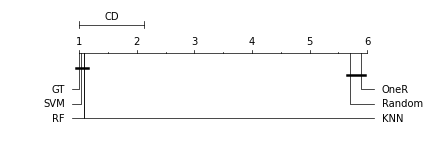

In [49]:
make_cd_diagram('Accuracy_avg[recommended]')

cd: 1.1239388092198597


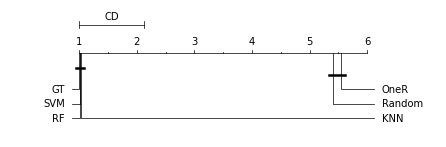

In [50]:
make_cd_diagram('Precision_avg[recommended]')

cd: 1.1239388092198597


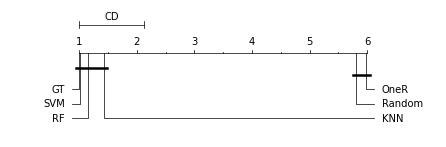

In [51]:
make_cd_diagram('Recall_avg[recommended]')

cd: 1.1239388092198597


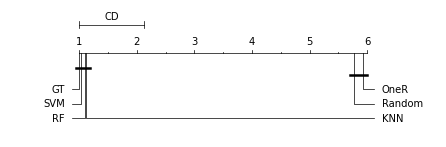

In [52]:
make_cd_diagram('F1_avg[recommended]')

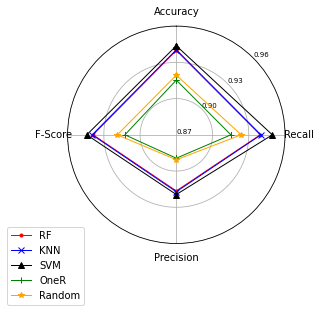

In [53]:
data = {
    'Algorithm': [],
    'Accuracy': [],
    'Recall': [],
    'Precision': [],
    'F-Score': []
}

for algorithm, metrics_df in metrics_dfs.items():
    data['Algorithm'].append(algorithm)
    data['Recall'].append(np.mean(metrics_df['Recall_avg[recommended]']))
    data['Accuracy'].append(np.mean(metrics_df['Accuracy_avg[recommended]']))
    data['F-Score'].append(np.mean(metrics_df['F1_avg[recommended]']))
    data['Precision'].append(np.mean(metrics_df['Precision_avg[recommended]']))

df = pd.DataFrame(data)

# ------- PART 1: Create background

# number of variable
categories = list(df)[1:]
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * math.pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
ax = plt.subplot(111, polar=True)

# If you want the first axis to be on top:
ax.set_theta_offset(math.pi / 2)
ax.set_theta_direction(-1)

# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)

# Draw ylabels
ax.set_rlabel_position(45)
plt.yticks([0.87, 0.9, 0.93, 0.96], ["0.87", "0.90", "0.93", "0.96"], color="black", size=7)
plt.ylim(0.87, 0.96)

# ------- PART 2: Add plots

# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable

# Ind1
algorithm = df.loc[0]['Algorithm']
values = df.loc[0].drop('Algorithm').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label=algorithm, color='red', marker='.')
#ax.fill(angles, values, 'b', alpha=0.1)

# Ind2
algorithm = df.loc[1]['Algorithm']
values = df.loc[1].drop('Algorithm').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label=algorithm, color='blue', marker='x')
#ax.fill(angles, values, 'r', alpha=0.1)

# Ind3
algorithm = df.loc[2]['Algorithm']
values = df.loc[2].drop('Algorithm').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label=algorithm, color='black', marker='^')
#ax.fill(angles, values, 'r', alpha=0.1)

# Ind4
algorithm = df.loc[3]['Algorithm']
values = df.loc[3].drop('Algorithm').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label=algorithm, color='green', marker='+')
#ax.fill(angles, values, 'r', alpha=0.1)

# Ind5
algorithm = df.loc[4]['Algorithm']
values = df.loc[4].drop('Algorithm').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label=algorithm, color='orange', marker='*')
#ax.fill(angles, values, 'b', alpha=0.1)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.savefig('radar.png', dpi=1200, bbox_inches='tight')
plt.show()